# TFM: Análisis de asociaciones en Twitter

# Dataset de Elecciones USA

In [22]:
#https://github.com/falcondai/python-snowflake
# using tweet id from https://twitter.com/falcondai/status/345063379196600321
import datetime

# twitter's snowflake parameters
twepoch = 1288834974657
datacenter_id_bits = 5
worker_id_bits = 5
sequence_id_bits = 12
max_datacenter_id = 1 << datacenter_id_bits
max_worker_id = 1 << worker_id_bits
max_sequence_id = 1 << sequence_id_bits
max_timestamp = 1 << (64 - datacenter_id_bits - worker_id_bits - sequence_id_bits)

def make_snowflake(timestamp_ms, datacenter_id, worker_id, sequence_id, twepoch=twepoch):
    """generate a twitter-snowflake id, based on 
    https://github.com/twitter/snowflake/blob/master/src/main/scala/com/twitter/service/snowflake/IdWorker.scala
    :param: timestamp_ms time since UNIX epoch in milliseconds"""

    sid = ((int(timestamp_ms) - twepoch) % max_timestamp) << datacenter_id_bits << worker_id_bits << sequence_id_bits
    sid += (datacenter_id % max_datacenter_id) << worker_id_bits << sequence_id_bits
    sid += (worker_id % max_worker_id) << sequence_id_bits
    sid += sequence_id % max_sequence_id

    return sid

def melt(snowflake_id, twepoch=twepoch):
    """inversely transform a snowflake id back to its parts."""
    sequence_id = snowflake_id & (max_sequence_id - 1)
    worker_id = (snowflake_id >> sequence_id_bits) & (max_worker_id - 1)
    datacenter_id = (snowflake_id >> sequence_id_bits >> worker_id_bits) & (max_datacenter_id - 1)
    timestamp_ms = snowflake_id >> sequence_id_bits >> worker_id_bits >> datacenter_id_bits
    timestamp_ms += twepoch

    return (timestamp_ms, int(datacenter_id), int(worker_id), int(sequence_id))

def local_datetime(timestamp_ms):
    """convert millisecond timestamp to local datetime object."""
    return datetime.datetime.fromtimestamp(timestamp_ms / 1000.)

if __name__ == '__main__':
    import time
    t0 = int(time.time() * 1000)
    #print(local_datetime(t0))
    assert(melt(make_snowflake(t0, 0, 0, 0))[0] == t0)



In [23]:
def sfk2time(snowflake_id):
    timestamp, data_center, worker, sequence = melt(snowflake_id)
    return local_datetime(timestamp)
    

In [24]:
def pandas2arff(df,filename,wekaname = "pandasdata",cleanstringdata=True,cleannan=True):
    """
    converts the pandas dataframe to a weka compatible file
    df: dataframe in pandas format
    filename: the filename you want the weka compatible file to be in
    wekaname: the name you want to give to the weka dataset (this will be visible to you when you open it in Weka)
    cleanstringdata: clean up data which may have spaces and replace with "_", special characters etc which seem to annoy Weka. 
                     To suppress this, set this to False
    cleannan: replaces all nan values with "?" which is Weka's standard for missing values. 
              To suppress this, set this to False
    """
    import re
    
    def cleanstring(s):
        if s!="?":
            return re.sub('[^A-Za-z0-9]+', "_", str(s))
        else:
            return "?"
            
    dfcopy = df #all cleaning operations get done on this copy

    
    if cleannan!=False:
        dfcopy = dfcopy.fillna(-999999999) #this is so that we can swap this out for "?"
        #this makes sure that certain numerical columns with missing values don't get stuck with "object" type
 
    f = open(filename,"w")
    arffList = []
    arffList.append("@relation " + wekaname + "\n")
    #look at each column's dtype. If it's an "object", make it "nominal" under Weka for now (can be changed in source for dates.. etc)
    for i in range(df.shape[1]):
        if dfcopy.dtypes[i]=='O' or (df.columns[i] in ["Class","CLASS","class"]):
            if cleannan!=False:
                dfcopy.iloc[:,i] = dfcopy.iloc[:,i].replace(to_replace=-999999999, value="?")
            if cleanstringdata!=False:
                dfcopy.iloc[:,i] = dfcopy.iloc[:,i].apply(cleanstring)
            _uniqueNominalVals = [str(_i) for _i in np.unique(dfcopy.iloc[:,i])]
            _uniqueNominalVals = ",".join(_uniqueNominalVals)
            _uniqueNominalVals = _uniqueNominalVals.replace("[","")
            _uniqueNominalVals = _uniqueNominalVals.replace("]","")
            _uniqueValuesString = "{" + _uniqueNominalVals +"}" 
            arffList.append("@attribute " + df.columns[i] + _uniqueValuesString + "\n")
        else:
            arffList.append("@attribute " + df.columns[i] + " real\n") 
            #even if it is an integer, let's just deal with it as a real number for now
    arffList.append("@data\n")           
    for i in range(dfcopy.shape[0]):#instances
        _instanceString = ""
        for j in range(df.shape[1]):#features
                if dfcopy.dtypes[j]=='O':
                    _instanceString+="\"" + str(dfcopy.iloc[i,j]) + "\""
                else:
                    _instanceString+=str(dfcopy.iloc[i,j])
                if j!=dfcopy.shape[1]-1:#if it's not the last feature, add a comma
                    _instanceString+=","
        _instanceString+="\n"
        if cleannan!=False:
            _instanceString = _instanceString.replace("-999999999.0","?") #for numeric missing values
            _instanceString = _instanceString.replace("\"?\"","?") #for categorical missing values
        arffList.append(_instanceString)
    f.writelines(arffList)
    f.close()
    del dfcopy
    return True

In [25]:
import pandas as pd
from snowflake import *
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 5000)

## Obtención del Dataset completo con datos ordenados en tiempo

In [26]:
data = './Desktop/data-all-annotations/testdata-taskA-all-annotations.txt'
df_a =  pd.read_csv(data, sep="\t",encoding="ISO-8859-1")
df_a_id =  pd.read_csv('./Desktop/data-all-annotations/testdata-taskA-ids.txt', sep="\t")
id_dic_a=df_a_id.set_index('ID').to_dict()
dic_a=id_dic_a["Tweet ID"]
df_a["ID"].replace(dic_a, inplace=True)
df_a["ID"] = df_a["ID"].map(sfk2time)
df_a.head()

ID   Target  \
0 2015-07-04 08:16:53.155  Atheism   
1 2015-07-04 08:22:15.910  Atheism   
2 2015-07-04 09:40:34.167  Atheism   
3 2015-07-04 11:39:08.286  Atheism   
4 2015-07-04 11:56:25.326  Atheism   

                                                                                                                                   Tweet  \
0  He who exalts himself shall be humbled; and he who humbles himself shall be exalted.Matt 23:12.     #SemST                              
1  RT @prayerbullets: I remove Nehushtan -previous moves of God that have become idols, from the high places -2 Kings 18:4 #SemST          
2  @Brainman365 @heidtjj @BenjaminLives I have sought the truth of my soul and found it strong enough to stand on its own merits. #SemST   
3  #God is utterly powerless without Human intervention... #SemST                                                                          
4  @David_Cameron   Miracles of #Multiculturalism   Miracles of shady 786  #Taqiya #Tawriya #Jaziya #Kafirs #Dhimmi #Jihad #Allah #SemST   

    Stance Opinion towards Sentiment  
0  AGAINST  TARGET          POSITIVE  
1  AGAINST  TARGET          NEITHER   
2  AGAINST  TARGET          POSITIVE  
3  AGAINST  TARGET          NEGATIVE  
4  AGAINST  OTHER           NEGATIVE

In [27]:
data = './Desktop/data-all-annotations/testdata-taskB-all-annotations.txt'
df_b =  pd.read_csv(data, sep="\t",encoding="ISO-8859-1")
df_b_id =  pd.read_csv('./Desktop/data-all-annotations/testdata-taskB-ids.txt', sep="\t")
id_dic_b=df_b_id.set_index('ID').to_dict()
dic_b=id_dic_b["Tweet ID"]
df_b["ID"].replace(dic_b, inplace=True)
df_b["ID"] = df_b["ID"].map(sfk2time)
df_b.head()

ID        Target  \
0 2015-06-25 18:51:16.812  Donald Trump   
1 2015-06-25 18:51:43.145  Donald Trump   
2 2015-06-25 19:09:18.731  Donald Trump   
3 2015-06-25 19:26:11.776  Donald Trump   
4 2015-06-25 19:36:53.840  Donald Trump   

                                                                                                                                Tweet  \
0  @2014voteblue @ChrisJZullo blindly supporting political parties is willfull ignorance, repub or dem. #SemST                          
1  @ThePimpernelX @Cameron_Gray @CalebHowe  Totally agree ...time to get out of the Twitter Peanut Gallery and take "arms #SemST        
2  @JeffYoung @ThePatriot143 I fully support full repeal. I will work for candidates who I believe will make it happen! #SemST          
3  @ABC Stupid is as stupid does! Showedhis true colors; seems that he ignores that US was invaded, & plundered,not discovered #SemST   
4  @HouseGOP we now have one political party. The Socialist party. No more BS. We don't believe you anymore. #SemST                     

    Stance Opinion towards Sentiment  
0  NONE     OTHER           NEGATIVE  
1  NONE     OTHER           POSITIVE  
2  NONE     OTHER           POSITIVE  
3  AGAINST  TARGET          NEGATIVE  
4  NONE     OTHER           NEGATIVE

In [28]:
data = './Desktop/data-all-annotations/trialdata-all-annotations.txt'
df_c =  pd.read_csv(data, sep="\t",encoding="ISO-8859-1")
df_c_id =  pd.read_csv('./Desktop/data-all-annotations/trialdata-ids.txt', sep="\t")
id_dic_c=df_c_id.set_index('ID').to_dict()
dic_c=id_dic_c["Tweet ID"]
df_c["ID"].replace(dic_c, inplace=True)
df_c["ID"] = df_c["ID"].map(sfk2time)
df_c.head()

ID           Target  \
0 2015-04-28 21:46:34.115  Hillary Clinton   
1 2015-04-15 21:44:25.402  Hillary Clinton   
2 2015-04-16 03:10:45.841  Hillary Clinton   
3 2015-04-15 18:56:46.964  Hillary Clinton   
4 2015-04-29 21:42:57.619  Hillary Clinton   

                                                                                                                             Tweet  \
0  @tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot   
1  Hillary is our best choice if we truly want to continue being a progressive nation. #Ohio                                         
2  @TheView I think our country is ready for a female pres, it can't ever be Hillary                                                 
3  I just gave an unhealthy amount of my hard-earned money away to the big gov't & untrustworthy IRS. #WhyImNotVotingForHillary      
4  @PortiaABoulger Thank you for adding me to your list                                                                              

    Stance Opinion towards Sentiment  
0  AGAINST  TARGET          NEGATIVE  
1  FAVOR    TARGET          POSITIVE  
2  AGAINST  TARGET          NEGATIVE  
3  AGAINST  TARGET          NEGATIVE  
4  NONE     NO ONE          POSITIVE

In [29]:
data = './Desktop/data-all-annotations/trainingdata-all-annotations.txt'
df_d =  pd.read_csv(data, sep="\t",encoding="ISO-8859-1")
df_d_id =  pd.read_csv('./Desktop/data-all-annotations/trainingdata-ids.txt', sep="\t")
id_dic_d=df_d_id.set_index('ID').to_dict()
dic_d=id_dic_d["Tweet ID"]
df_d["ID"].replace(dic_d, inplace=True)
df_d["ID"] = df_d["ID"].map(sfk2time)
df_d.head()

ID   Target  \
0 2015-04-15 18:57:22.118  Atheism   
1 2015-04-15 19:00:01.823  Atheism   
2 2015-04-15 19:01:53.466  Atheism   
3 2015-04-15 19:20:13.487  Atheism   
4 2015-04-15 19:25:03.447  Atheism   

                                                                                                                                         Tweet  \
0  dear lord thank u for all of ur blessings forgive my sins lord give me strength and energy for this busy day ahead #blessed #hope #SemST      
1  Blessed are the peacemakers, for they shall be called children of God. Matthew 5:9 #scripture #peace #SemST                                   
2  I am not conformed to this world. I am transformed by the renewing of my mind. #ISpeakLife #God #2014 #SemST                                  
3  Salah should be prayed with #focus and #understanding. #Allah warns against #lazy prayers done just for #show Surah Al-Maoon 107:4-6 #SemST   
4  And stay in your houses and do not display yourselves like that of the times of ignorance." [Quran 33:33].#islam #SemST                       

    Stance Opinion towards Sentiment  
0  AGAINST  OTHER           POSITIVE  
1  AGAINST  OTHER           POSITIVE  
2  AGAINST  OTHER           POSITIVE  
3  AGAINST  OTHER           POSITIVE  
4  AGAINST  OTHER           NEGATIVE

### Mergind DFs

In [30]:
df_usa = pd.concat([df_a, df_b,df_c,df_d])
df_usa = df_usa.sort_values(by="ID",ascending=True)
df_usa = df_usa.reset_index()
del df_usa["index"]
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                                   Tweet  \
0  CEO pay the target for 2016 election. From someone who makes more than most CEO's but you drank the Kool-Aid.                           
1  RT @GunnJessica: Because I want young American women to be able to be proud of the 1st woman president #SemST                           
2  @readyforHRC @HillaryClinton #HillaryClinton, the US presidency is a testament to the success of #women their role in the world         
3  @Chris_1791 @newsbusters 2 years ago #Hillary never answered whether she used private email #Liberal media passed on reporting #SemST   
4  I'm on the edge of my seat to start volunteering for @HillaryClinton 's presidential campaign!  So excited!!  #cantwait                 

    Stance Opinion towards Sentiment  
0  NONE     OTHER           NEGATIVE  
1  FAVOR    OTHER           POSITIVE  
2  FAVOR    TARGET          POSITIVE  
3  AGAINST  TARGET          NEGATIVE  
4  FAVOR    TARGET          POSITIVE

## Análisis Dataset de Elecciones USA

##### Limpieza de texto

In [31]:
import re
df_usa["Tweet"]=df_usa["Tweet"].apply(lambda x: re.split('https:\/\/.*', str(x))[0]) #Links
df_usa["Tweet"] = df_usa["Tweet"].str.replace("\b(ha)+|l(ol)+\b",'')                 #Risas
df_usa['Tweet'] = df_usa['Tweet'].str.replace('RT', '')                              #RTS
df_usa['Tweet'] = df_usa['Tweet'].str.replace("\'",' ')                              #Eliminamos acortaciones
df_usa["Tweet"] = df_usa["Tweet"].str.replace('\n', ' ')                             #Saltos de linea
df_usa['Tweet'] = df_usa['Tweet'].str.replace('\d+', '')                             #Numeros
df_usa['Tweet'] = df_usa['Tweet'].str.replace('º', '')
df_usa['Tweet'] = df_usa['Tweet'].str.replace('_', '')
df_usa['Tweet'] = df_usa['Tweet'].str.replace('[^\w\s#@]',' ')                       #Eliminar puntuaciones pero NO los "#", ni "@" 
df_usa["Tweet"]=df_usa["Tweet"].apply(lambda x: re.sub(r'(.)\1{2,}', r'\1', x))      #Eliminar multiples letras consecutivas
df_usa['Tweet'] = df_usa['Tweet'].str.replace('  ',' ').str.lstrip()
df_usa['Tweet'] = df_usa['Tweet'].str.lower()

In [32]:
import unicodedata
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore').decode("utf-8") 
    return only_ascii

In [33]:
df_usa['Tweet'] = df_usa['Tweet'].map(remove_accents)

#### Tokenization

In [34]:
df_usa['Token_Tweet']=df_usa['Tweet'].str.split(" ").apply(lambda x: [item for item in x if item])

##### Remove StopWords + POS-TAGGER

In [35]:
import spacy
from nltk.corpus import stopwords
from nltk import pos_tag

spacy_nlp = spacy.load("en_core_web_sm")
stopw = set(stopwords.words('english')+["theyre","im","youre","hes","shes","its","thats"]+list(spacy.lang.en.stop_words.STOP_WORDS))

In [36]:
def twitter_entities(word_text):
    if word_text[0]=="@":
        tag = "USER"
    elif word_text[0]=="#":
        tag = "HASHTAG"
    return tag

In [37]:
def text_tagger(text_list,stopwords):
    new_text = [item for item in text_list if item not in stopwords and len(item) > 2]
    postag = [item[1] for item in pos_tag(new_text)]
    tag_text = [postag[i] if new_text[i][0] not in ["@","#"] else twitter_entities(new_text[i]) for i in range(0,len(new_text))]  
    return " ".join(new_text).replace('  ',' ').lstrip(),new_text,tag_text

In [38]:
df_usa['Analyzed_Tweet'],df_usa['Token_Analyzed_Tweet'],df_usa['Token_POSTag'] = zip(*df_usa.apply(lambda x: text_tagger(x['Token_Tweet'],stopw), axis=1))
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                            Tweet  \
0  ceo pay the target for election from someone who makes more than most ceo s but you drank the kool aid                           
1  @gunnjessica because i want young american women to be able to be proud of the st woman president #semst                         
2  @readyforhrc @hillaryclinton #hillaryclinton the us presidency is a testament to the success of #women their role in the world   
3  @chris @newsbusters years ago #hillary never answered whether she used private email #liberal media passed on reporting #semst   
4  i m on the edge of my seat to start volunteering for @hillaryclinton s presidential campaign so excited #cantwait                

    Stance Opinion towards Sentiment  \
0  NONE     OTHER           NEGATIVE   
1  FAVOR    OTHER           POSITIVE   
2  FAVOR    TARGET          POSITIVE   
3  AGAINST  TARGET          NEGATIVE   
4  FAVOR    TARGET          POSITIVE   

                                                                                                                                          Token_Tweet  \
0  [ceo, pay, the, target, for, election, from, someone, who, makes, more, than, most, ceo, s, but, you, drank, the, kool, aid]                         
1  [@gunnjessica, because, i, want, young, american, women, to, be, able, to, be, proud, of, the, st, woman, president, #semst]                         
2  [@readyforhrc, @hillaryclinton, #hillaryclinton, the, us, presidency, is, a, testament, to, the, success, of, #women, their, role, in, the, world]   
3  [@chris, @newsbusters, years, ago, #hillary, never, answered, whether, she, used, private, email, #liberal, media, passed, on, reporting, #semst]    
4  [i, m, on, the, edge, of, my, seat, to, start, volunteering, for, @hillaryclinton, s, presidential, campaign, so, excited, #cantwait]                

                                                                                         Analyzed_Tweet  \
0  ceo pay target election makes ceo drank kool aid                                                       
1  @gunnjessica want young american women able proud woman president #semst                               
2  @readyforhrc @hillaryclinton #hillaryclinton presidency testament success #women role world            
3  @chris @newsbusters years ago #hillary answered private email #liberal media passed reporting #semst   
4  edge seat start volunteering @hillaryclinton presidential campaign excited #cantwait                   

                                                                                                 Token_Analyzed_Tweet  \
0  [ceo, pay, target, election, makes, ceo, drank, kool, aid]                                                           
1  [@gunnjessica, want, young, american, women, able, proud, woman, president, #semst]                                  
2  [@readyforhrc, @hillaryclinton, #hillaryclinton, presidency, testament, success, #women, role, world]                
3  [@chris, @newsbusters, years, ago, #hillary, answered, private, email, #liberal, media, passed, reporting, #semst]   
4  [edge, seat, start, volunteering, @hillaryclinton, presidential, campaign, excited, #cantwait]                       

                                                                   Token_POSTag  
0  [JJ, NN, NN, NN, VBZ, JJ, JJ, NN, NN]                                         
1  [USER, VBP, JJ, JJ, NNS, JJ, JJ, NN, NN, HASHTAG]                             
2  [USER, USER, HASHTAG, NN, NN, NN, HASHTAG, NN, NN]                            
3  [USER, USER, NNS, RB, HASHTAG, VBD, JJ, JJ, HASHTAG, NNS, VBD, VBG, HASHTAG]  
4  [NN,

#### Formato fecha

In [39]:
from datetime import datetime
def date_format(input_date):
    return input_date.day, input_date.month, str(input_date.month)+"-"+str(input_date.day)+"-"+str(input_date.year)

In [40]:
df_usa["Day"],df_usa["Month"],df_usa["Date"] = zip(*df_usa['ID'].map(date_format))
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                            Tweet  \
0  ceo pay the target for election from someone who makes more than most ceo s but you drank the kool aid                           
1  @gunnjessica because i want young american women to be able to be proud of the st woman president #semst                         
2  @readyforhrc @hillaryclinton #hillaryclinton the us presidency is a testament to the success of #women their role in the world   
3  @chris @newsbusters years ago #hillary never answered whether she used private email #liberal media passed on reporting #semst   
4  i m on the edge of my seat to start volunteering for @hillaryclinton s presidential campaign so excited #cantwait                

    Stance Opinion towards Sentiment  \
0  NONE     OTHER           NEGATIVE   
1  FAVOR    OTHER           POSITIVE   
2  FAVOR    TARGET          POSITIVE   
3  AGAINST  TARGET          NEGATIVE   
4  FAVOR    TARGET          POSITIVE   

                                                                                                                                          Token_Tweet  \
0  [ceo, pay, the, target, for, election, from, someone, who, makes, more, than, most, ceo, s, but, you, drank, the, kool, aid]                         
1  [@gunnjessica, because, i, want, young, american, women, to, be, able, to, be, proud, of, the, st, woman, president, #semst]                         
2  [@readyforhrc, @hillaryclinton, #hillaryclinton, the, us, presidency, is, a, testament, to, the, success, of, #women, their, role, in, the, world]   
3  [@chris, @newsbusters, years, ago, #hillary, never, answered, whether, she, used, private, email, #liberal, media, passed, on, reporting, #semst]    
4  [i, m, on, the, edge, of, my, seat, to, start, volunteering, for, @hillaryclinton, s, presidential, campaign, so, excited, #cantwait]                

                                                                                         Analyzed_Tweet  \
0  ceo pay target election makes ceo drank kool aid                                                       
1  @gunnjessica want young american women able proud woman president #semst                               
2  @readyforhrc @hillaryclinton #hillaryclinton presidency testament success #women role world            
3  @chris @newsbusters years ago #hillary answered private email #liberal media passed reporting #semst   
4  edge seat start volunteering @hillaryclinton presidential campaign excited #cantwait                   

                                                                                                 Token_Analyzed_Tweet  \
0  [ceo, pay, target, election, makes, ceo, drank, kool, aid]                                                           
1  [@gunnjessica, want, young, american, women, able, proud, woman, president, #semst]                                  
2  [@readyforhrc, @hillaryclinton, #hillaryclinton, presidency, testament, success, #women, role, world]                
3  [@chris, @newsbusters, years, ago, #hillary, answered, private, email, #liberal, media, passed, reporting, #semst]   
4  [edge, seat, start, volunteering, @hillaryclinton, presidential, campaign, excited, #cantwait]                       

                                                                   Token_POSTag  \
0  [JJ, NN, NN, NN, VBZ, JJ, JJ, NN, NN]                                          
1  [USER, VBP, JJ, JJ, NNS, JJ, JJ, NN, NN, HASHTAG]                              
2  [USER, USER, HASHTAG, NN, NN, NN, HASHTAG, NN, NN]                             
3  [USER, USER, NNS, RB, HASHTAG, VBD, JJ, JJ, HASHTAG, NNS, VBD, VBG, HASHTAG]   
4 

##### Eliminar elementos no-útiles

In [41]:
def simplif_text(text_list,text_tag):
    for i,tag in sorted(enumerate(text_tag),reverse=True):
        if tag not in ("FW", "JJ", "JJS", "JJR", "LS", "NN", "NNS", "NNP", "NNPS" ,"USER", "HASHTAG"):
            del text_tag[i]
            del text_list[i]
    return " ".join(text_list).replace('  ',' ').lstrip(),text_list,text_tag

In [42]:
df_usa['Analyzed_Tweet'],df_usa['Token_Analyzed_Tweet'],df_usa['Token_POSTag'] = zip(*df_usa.apply(lambda x: simplif_text(x['Token_Analyzed_Tweet'],x['Token_POSTag'] ), axis=1))
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                            Tweet  \
0  ceo pay the target for election from someone who makes more than most ceo s but you drank the kool aid                           
1  @gunnjessica because i want young american women to be able to be proud of the st woman president #semst                         
2  @readyforhrc @hillaryclinton #hillaryclinton the us presidency is a testament to the success of #women their role in the world   
3  @chris @newsbusters years ago #hillary never answered whether she used private email #liberal media passed on reporting #semst   
4  i m on the edge of my seat to start volunteering for @hillaryclinton s presidential campaign so excited #cantwait                

    Stance Opinion towards Sentiment  \
0  NONE     OTHER           NEGATIVE   
1  FAVOR    OTHER           POSITIVE   
2  FAVOR    TARGET          POSITIVE   
3  AGAINST  TARGET          NEGATIVE   
4  FAVOR    TARGET          POSITIVE   

                                                                                                                                          Token_Tweet  \
0  [ceo, pay, the, target, for, election, from, someone, who, makes, more, than, most, ceo, s, but, you, drank, the, kool, aid]                         
1  [@gunnjessica, because, i, want, young, american, women, to, be, able, to, be, proud, of, the, st, woman, president, #semst]                         
2  [@readyforhrc, @hillaryclinton, #hillaryclinton, the, us, presidency, is, a, testament, to, the, success, of, #women, their, role, in, the, world]   
3  [@chris, @newsbusters, years, ago, #hillary, never, answered, whether, she, used, private, email, #liberal, media, passed, on, reporting, #semst]    
4  [i, m, on, the, edge, of, my, seat, to, start, volunteering, for, @hillaryclinton, s, presidential, campaign, so, excited, #cantwait]                

                                                                                Analyzed_Tweet  \
0  ceo pay target election ceo drank kool aid                                                    
1  @gunnjessica young american women able proud woman president #semst                           
2  @readyforhrc @hillaryclinton #hillaryclinton presidency testament success #women role world   
3  @chris @newsbusters years #hillary private email #liberal media #semst                        
4  edge seat @hillaryclinton presidential campaign #cantwait                                     

                                                                                    Token_Analyzed_Tweet  \
0  [ceo, pay, target, election, ceo, drank, kool, aid]                                                     
1  [@gunnjessica, young, american, women, able, proud, woman, president, #semst]                           
2  [@readyforhrc, @hillaryclinton, #hillaryclinton, presidency, testament, success, #women, role, world]   
3  [@chris, @newsbusters, years, #hillary, private, email, #liberal, media, #semst]                        
4  [edge, seat, @hillaryclinton, presidential, campaign, #cantwait]                                        

                                                Token_POSTag  Day  Month  \
0  [JJ, NN, NN, NN, JJ, JJ, NN, NN]                           15   4       
1  [USER, JJ, JJ, NNS, JJ, JJ, NN, NN, HASHTAG]               15   4       
2  [USER, USER, HASHTAG, NN, NN, NN, HASHTAG, NN, NN]         15   4       
3  [USER, USER, NNS, HASHTAG, JJ, JJ, HASHTAG, NNS, HASHTAG]  15   4       
4  [NN, NN, USER, JJ, NN, HASHTAG]                            15   4       

        Date  
0  4-15-2015  
1  4-15-2015  
2  4-15-2015  
3  4-15-2015  
4  4-15-2015

#### Lematization

In [43]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [44]:
def text_lemmatizer(text_list,text_tags):
    lemma=[wordnet_lemmatizer.lemmatize(text_list[item]) if text_tags[item] not in ["HASHTAG", "USER"] else text_list[item] for item in range(0,len(text_tags))]
    return " ".join(lemma).replace('  ',' ').lstrip(),lemma

In [45]:
df_usa['Analyzed_Tweet'],df_usa['Token_Analyzed_Tweet'] = zip(*df_usa.apply(lambda x: text_lemmatizer(x['Token_Analyzed_Tweet'],x['Token_POSTag'] ), axis=1))
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                            Tweet  \
0  ceo pay the target for election from someone who makes more than most ceo s but you drank the kool aid                           
1  @gunnjessica because i want young american women to be able to be proud of the st woman president #semst                         
2  @readyforhrc @hillaryclinton #hillaryclinton the us presidency is a testament to the success of #women their role in the world   
3  @chris @newsbusters years ago #hillary never answered whether she used private email #liberal media passed on reporting #semst   
4  i m on the edge of my seat to start volunteering for @hillaryclinton s presidential campaign so excited #cantwait                

    Stance Opinion towards Sentiment  \
0  NONE     OTHER           NEGATIVE   
1  FAVOR    OTHER           POSITIVE   
2  FAVOR    TARGET          POSITIVE   
3  AGAINST  TARGET          NEGATIVE   
4  FAVOR    TARGET          POSITIVE   

                                                                                                                                          Token_Tweet  \
0  [ceo, pay, the, target, for, election, from, someone, who, makes, more, than, most, ceo, s, but, you, drank, the, kool, aid]                         
1  [@gunnjessica, because, i, want, young, american, women, to, be, able, to, be, proud, of, the, st, woman, president, #semst]                         
2  [@readyforhrc, @hillaryclinton, #hillaryclinton, the, us, presidency, is, a, testament, to, the, success, of, #women, their, role, in, the, world]   
3  [@chris, @newsbusters, years, ago, #hillary, never, answered, whether, she, used, private, email, #liberal, media, passed, on, reporting, #semst]    
4  [i, m, on, the, edge, of, my, seat, to, start, volunteering, for, @hillaryclinton, s, presidential, campaign, so, excited, #cantwait]                

                                                                                Analyzed_Tweet  \
0  ceo pay target election ceo drank kool aid                                                    
1  @gunnjessica young american woman able proud woman president #semst                           
2  @readyforhrc @hillaryclinton #hillaryclinton presidency testament success #women role world   
3  @chris @newsbusters year #hillary private email #liberal medium #semst                        
4  edge seat @hillaryclinton presidential campaign #cantwait                                     

                                                                                    Token_Analyzed_Tweet  \
0  [ceo, pay, target, election, ceo, drank, kool, aid]                                                     
1  [@gunnjessica, young, american, woman, able, proud, woman, president, #semst]                           
2  [@readyforhrc, @hillaryclinton, #hillaryclinton, presidency, testament, success, #women, role, world]   
3  [@chris, @newsbusters, year, #hillary, private, email, #liberal, medium, #semst]                        
4  [edge, seat, @hillaryclinton, presidential, campaign, #cantwait]                                        

                                                Token_POSTag  Day  Month  \
0  [JJ, NN, NN, NN, JJ, JJ, NN, NN]                           15   4       
1  [USER, JJ, JJ, NNS, JJ, JJ, NN, NN, HASHTAG]               15   4       
2  [USER, USER, HASHTAG, NN, NN, NN, HASHTAG, NN, NN]         15   4       
3  [USER, USER, NNS, HASHTAG, JJ, JJ, HASHTAG, NNS, HASHTAG]  15   4       
4  [NN, NN, USER, JJ, NN, HASHTAG]                            15   4       

        Date  
0  4-15-2015  
1  4-15-2015  
2  4-15-2015  
3  4-15-2015  
4  4-15-2015

### N_GRAMS

In [46]:
from nltk import ngrams
from collections import Counter

#Buscar N-gramas frecuentes, considerarlos en el texto
def grams_remove(old_text,old_tagpos,gram_list,gram_len):
    length=len(old_text)
    new_text=old_text[:]
    new_tagpos = old_tagpos[:]
    rem_idx=[]
    for gram in gram_list:
        for i in range(0,length+1-gram_len):
            if tuple(new_text[i:i+gram_len]) == gram:
                new_text[i]="_".join(gram)
                new_tagpos[i]="NGRAM"
                for k in range(i+1,i+gram_len):
                    rem_idx.append(k)
    for idx in sorted(rem_idx, reverse=True):
        del new_text[idx]
        del new_tagpos[idx]
    return " ".join(new_text).replace('  ',' ').lstrip(),new_text, new_tagpos

In [47]:
#Eliminar grams acabados con un hashtag. 
def rem_hashgrams(list_gram):
    rem_idx=[]
    for i in range(0,len(list_gram)):
        if list_gram[i][0][-1][0] == "#":
            rem_idx.append(i)
    for j in sorted(rem_idx,reverse=True):
        del list_gram[j]
    return list_gram

#### 3-gramas

In [48]:
trigram_list = [pair for row in df_usa['Token_Analyzed_Tweet'] for pair in ngrams(row, 3)] 
tricounts = (Counter(trigram_list).most_common(200))
count_trigrams=pd.DataFrame.from_records(tricounts, columns=['gram', 'count'])
count_trigrams=count_trigrams[count_trigrams["count"]>3]
count_trigrams.head(100)
count_trigrams=count_trigrams.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47])
list_trigram=count_trigrams["gram"].tolist()
list_trigram

/Users/pj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: generator 'ngrams' raised StopIteration
  """Entry point for launching an IPython kernel.


[('anti', 'choice', 'law')]

In [50]:
df_usa["Analyzed_Tweet"],df_usa["Token_Analyzed_Tweet"],df_usa['Token_POSTag'] = zip(*df_usa.apply(lambda x: grams_remove(x['Token_Analyzed_Tweet'],x['Token_POSTag'], list_trigram,3), axis=1))

#### 2-gramas

In [51]:
bigram_list = [pair for row in df_usa['Token_Analyzed_Tweet'] for pair in ngrams(row, 2)]
bicounts = rem_hashgrams(Counter(bigram_list).most_common(200))
count_bigrams=pd.DataFrame.from_records(bicounts, columns=['gram', 'count'])
count_bigrams=count_bigrams[count_bigrams["count"]>3]
count_bigrams=count_bigrams.drop([3,7,11,12,13,15,16,18,19,21,23,24,26,27,28,29,31,32,33,37,38,40,41,42,43,44,45,46,47,48,49,51,52,54,55,58,59,60,62,62,63,64,65,66,68,69])
count_bigrams.head(50)

gram  count
0   (donald, trump)       42   
1   (climate, change)     39   
2   (hillary, clinton)    37   
4   (men, woman)          22   
5   (pro, life)           20   
6   (equal, right)        18   
8   (white, house)        16   
9   (human, right)        15   
10  (gay, marriage)       15   
14  (pro, choice)         14   
17  (unborn, child)       12   
20  (human, life)         10   
22  (unborn, baby)        9    
25  (supreme, court)      9    
30  (marriage, equality)  7    
34  (united, state)       7    
35  (confederate, flag)   7    
36  (sea, level)          7    
39  (right, human)        6    
50  (global, warming)     6    
53  (human, being)        6    
56  (social, medium)      6    
57  (birth, control)      6    
61  (regard, dion)        6    
67  (death, penalty)      5    
70  (woman, child)        5

In [52]:
list_bigram=count_bigrams["gram"].tolist()+[("preborn","child"),("gender","equality")]
list_bigram

[('donald', 'trump'),
 ('climate', 'change'),
 ('hillary', 'clinton'),
 ('men', 'woman'),
 ('pro', 'life'),
 ('equal', 'right'),
 ('white', 'house'),
 ('human', 'right'),
 ('gay', 'marriage'),
 ('pro', 'choice'),
 ('unborn', 'child'),
 ('human', 'life'),
 ('unborn', 'baby'),
 ('supreme', 'court'),
 ('marriage', 'equality'),
 ('united', 'state'),
 ('confederate', 'flag'),
 ('sea', 'level'),
 ('right', 'human'),
 ('global', 'warming'),
 ('human', 'being'),
 ('social', 'medium'),
 ('birth', 'control'),
 ('regard', 'dion'),
 ('death', 'penalty'),
 ('woman', 'child'),
 ('preborn', 'child'),
 ('gender', 'equality')]

In [53]:
df_usa["Analyzed_Tweet"],df_usa["Token_Analyzed_Tweet"],df_usa['Token_POSTag'] = zip(*df_usa.apply(lambda x: grams_remove(x['Token_Analyzed_Tweet'],x['Token_POSTag'], list_bigram,2), axis=1))
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                            Tweet  \
0  ceo pay the target for election from someone who makes more than most ceo s but you drank the kool aid                           
1  @gunnjessica because i want young american women to be able to be proud of the st woman president #semst                         
2  @readyforhrc @hillaryclinton #hillaryclinton the us presidency is a testament to the success of #women their role in the world   
3  @chris @newsbusters years ago #hillary never answered whether she used private email #liberal media passed on reporting #semst   
4  i m on the edge of my seat to start volunteering for @hillaryclinton s presidential campaign so excited #cantwait                

    Stance Opinion towards Sentiment  \
0  NONE     OTHER           NEGATIVE   
1  FAVOR    OTHER           POSITIVE   
2  FAVOR    TARGET          POSITIVE   
3  AGAINST  TARGET          NEGATIVE   
4  FAVOR    TARGET          POSITIVE   

                                                                                                                                          Token_Tweet  \
0  [ceo, pay, the, target, for, election, from, someone, who, makes, more, than, most, ceo, s, but, you, drank, the, kool, aid]                         
1  [@gunnjessica, because, i, want, young, american, women, to, be, able, to, be, proud, of, the, st, woman, president, #semst]                         
2  [@readyforhrc, @hillaryclinton, #hillaryclinton, the, us, presidency, is, a, testament, to, the, success, of, #women, their, role, in, the, world]   
3  [@chris, @newsbusters, years, ago, #hillary, never, answered, whether, she, used, private, email, #liberal, media, passed, on, reporting, #semst]    
4  [i, m, on, the, edge, of, my, seat, to, start, volunteering, for, @hillaryclinton, s, presidential, campaign, so, excited, #cantwait]                

                                                                                Analyzed_Tweet  \
0  ceo pay target election ceo drank kool aid                                                    
1  @gunnjessica young american woman able proud woman president #semst                           
2  @readyforhrc @hillaryclinton #hillaryclinton presidency testament success #women role world   
3  @chris @newsbusters year #hillary private email #liberal medium #semst                        
4  edge seat @hillaryclinton presidential campaign #cantwait                                     

                                                                                    Token_Analyzed_Tweet  \
0  [ceo, pay, target, election, ceo, drank, kool, aid]                                                     
1  [@gunnjessica, young, american, woman, able, proud, woman, president, #semst]                           
2  [@readyforhrc, @hillaryclinton, #hillaryclinton, presidency, testament, success, #women, role, world]   
3  [@chris, @newsbusters, year, #hillary, private, email, #liberal, medium, #semst]                        
4  [edge, seat, @hillaryclinton, presidential, campaign, #cantwait]                                        

                                                Token_POSTag  Day  Month  \
0  [JJ, NN, NN, NN, JJ, JJ, NN, NN]                           15   4       
1  [USER, JJ, JJ, NNS, JJ, JJ, NN, NN, HASHTAG]               15   4       
2  [USER, USER, HASHTAG, NN, NN, NN, HASHTAG, NN, NN]         15   4       
3  [USER, USER, NNS, HASHTAG, JJ, JJ, HASHTAG, NNS, HASHTAG]  15   4       
4  [NN, NN, USER, JJ, NN, HASHTAG]                            15   4       

        Date  
0  4-15-2015  
1  4-15-2015  
2  4-15-2015  
3  4-15-2015  
4  4-15-2015

#### Unify Entities

In [54]:
def unify_ent(old_text,diccionary):
    new_text = old_text[:]
    for i in range(0,len(old_text)):
        if old_text[i] in diccionary:
            new_text[i]=diccionary[old_text[i]][0]
    return " ".join(new_text).replace('  ',' ').lstrip(),new_text

In [55]:
trump = ["@realdonaldtrump","donald_trump","mr_trump","trump","#trump","donald","#donaldtrump","donaldtrump"]
dic_trump= dict.fromkeys(trump, "donald_trump")
hillary = ["@hillaryclinton","#hillaryclinton","hillaryclinton","hillary","clinton","hilary","#stophillary","#stophillarypac","hillary_clinton","#hillary","killary","#killary","nohillary","#nohillary","#readyforhillary","readyforhillary"]
dic_hillary= dict.fromkeys(hillary, "hillary_clinton")
democrats=["@thedemocrats","@vademocrats","democrats","democrat","#democrats","#democrat"]
dic_dem =  dict.fromkeys(democrats, "democrat")
republican= ["republican","republicans","#republican","#republicans", "#republicanvalues"]
dic_rep = dict.fromkeys(republican,"republican")
obama = ["#obama","obama","@barackobama","barackobama"]
dic_obama=dict.fromkeys(obama,"barack_obama")
usa = ["#unitedstates","united_states","usa","@unitedstates"]
dic_usa = dict.fromkeys(usa,"USA")
scotus = ["#scotus","scotus","supreme_court","supremecourt","#supremecourt"]
dic_scotus = dict.fromkeys(scotus,"SCOTUS")
davidatt = ["@sir_attenboroug","david_attenboroug","attenborough","davidattenboroug"]
dic_david= dict.fromkeys(davidatt, "david_attenboroug")
chris = ["îchristopher"]
dic_chris = dict.fromkeys(chris,"christopher")
dicts = [dic_trump,dic_hillary,dic_usa,dic_david,dic_chris,dic_scotus,dic_obama,dic_dem,dic_rep]
super_dict = {}
for d in dicts:
    for k, v in d.items():
        super_dict.setdefault(k, []).append(v)

In [56]:
df_usa["Analyzed_Tweet"],df_usa["Token_Analyzed_Tweet"] = zip(*df_usa.apply(lambda x: unify_ent(x['Token_Analyzed_Tweet'],super_dict), axis=1))
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                            Tweet  \
0  ceo pay the target for election from someone who makes more than most ceo s but you drank the kool aid                           
1  @gunnjessica because i want young american women to be able to be proud of the st woman president #semst                         
2  @readyforhrc @hillaryclinton #hillaryclinton the us presidency is a testament to the success of #women their role in the world   
3  @chris @newsbusters years ago #hillary never answered whether she used private email #liberal media passed on reporting #semst   
4  i m on the edge of my seat to start volunteering for @hillaryclinton s presidential campaign so excited #cantwait                

    Stance Opinion towards Sentiment  \
0  NONE     OTHER           NEGATIVE   
1  FAVOR    OTHER           POSITIVE   
2  FAVOR    TARGET          POSITIVE   
3  AGAINST  TARGET          NEGATIVE   
4  FAVOR    TARGET          POSITIVE   

                                                                                                                                          Token_Tweet  \
0  [ceo, pay, the, target, for, election, from, someone, who, makes, more, than, most, ceo, s, but, you, drank, the, kool, aid]                         
1  [@gunnjessica, because, i, want, young, american, women, to, be, able, to, be, proud, of, the, st, woman, president, #semst]                         
2  [@readyforhrc, @hillaryclinton, #hillaryclinton, the, us, presidency, is, a, testament, to, the, success, of, #women, their, role, in, the, world]   
3  [@chris, @newsbusters, years, ago, #hillary, never, answered, whether, she, used, private, email, #liberal, media, passed, on, reporting, #semst]    
4  [i, m, on, the, edge, of, my, seat, to, start, volunteering, for, @hillaryclinton, s, presidential, campaign, so, excited, #cantwait]                

                                                                                Analyzed_Tweet  \
0  ceo pay target election ceo drank kool aid                                                    
1  @gunnjessica young american woman able proud woman president #semst                           
2  @readyforhrc hillary_clinton hillary_clinton presidency testament success #women role world   
3  @chris @newsbusters year hillary_clinton private email #liberal medium #semst                 
4  edge seat hillary_clinton presidential campaign #cantwait                                     

                                                                                    Token_Analyzed_Tweet  \
0  [ceo, pay, target, election, ceo, drank, kool, aid]                                                     
1  [@gunnjessica, young, american, woman, able, proud, woman, president, #semst]                           
2  [@readyforhrc, hillary_clinton, hillary_clinton, presidency, testament, success, #women, role, world]   
3  [@chris, @newsbusters, year, hillary_clinton, private, email, #liberal, medium, #semst]                 
4  [edge, seat, hillary_clinton, presidential, campaign, #cantwait]                                        

                                                Token_POSTag  Day  Month  \
0  [JJ, NN, NN, NN, JJ, JJ, NN, NN]                           15   4       
1  [USER, JJ, JJ, NNS, JJ, JJ, NN, NN, HASHTAG]               15   4       
2  [USER, USER, HASHTAG, NN, NN, NN, HASHTAG, NN, NN]         15   4       
3  [USER, USER, NNS, HASHTAG, JJ, JJ, HASHTAG, NNS, HASHTAG]  15   4       
4  [NN, NN, USER, JJ, NN, HASHTAG]                            15   4       

        Date  
0  4-15-2015  
1  4-15-2015  
2  4-15-2015  
3  4-15-2015  
4  4-15-2015

#### Hashtags normalization

In [57]:
#Parece lógico eliminar el símbolo de usuarios y hashtags para considerar posibles coincidencias entre terminos
def tweet_lemmatizer(text_list,text_tags):
    new_text = text_list[:]
    for i,word in enumerate(text_list):
            new_text[i] = word.replace('#','').replace('@','')  
    lemma=[wordnet_lemmatizer.lemmatize(new_text[item]) if text_tags[item] not in ["USER","GRAM"] else new_text[item] for item in range(0,len(text_tags))]    
    return " ".join(lemma).replace('  ',' ').lstrip(),lemma

In [58]:
df_usa['Analyzed_Tweet'],df_usa['Token_Analyzed_Tweet'] = zip(*df_usa.apply(lambda x: tweet_lemmatizer(x['Token_Analyzed_Tweet'],x['Token_POSTag'] ), axis=1))
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                            Tweet  \
0  ceo pay the target for election from someone who makes more than most ceo s but you drank the kool aid                           
1  @gunnjessica because i want young american women to be able to be proud of the st woman president #semst                         
2  @readyforhrc @hillaryclinton #hillaryclinton the us presidency is a testament to the success of #women their role in the world   
3  @chris @newsbusters years ago #hillary never answered whether she used private email #liberal media passed on reporting #semst   
4  i m on the edge of my seat to start volunteering for @hillaryclinton s presidential campaign so excited #cantwait                

    Stance Opinion towards Sentiment  \
0  NONE     OTHER           NEGATIVE   
1  FAVOR    OTHER           POSITIVE   
2  FAVOR    TARGET          POSITIVE   
3  AGAINST  TARGET          NEGATIVE   
4  FAVOR    TARGET          POSITIVE   

                                                                                                                                          Token_Tweet  \
0  [ceo, pay, the, target, for, election, from, someone, who, makes, more, than, most, ceo, s, but, you, drank, the, kool, aid]                         
1  [@gunnjessica, because, i, want, young, american, women, to, be, able, to, be, proud, of, the, st, woman, president, #semst]                         
2  [@readyforhrc, @hillaryclinton, #hillaryclinton, the, us, presidency, is, a, testament, to, the, success, of, #women, their, role, in, the, world]   
3  [@chris, @newsbusters, years, ago, #hillary, never, answered, whether, she, used, private, email, #liberal, media, passed, on, reporting, #semst]    
4  [i, m, on, the, edge, of, my, seat, to, start, volunteering, for, @hillaryclinton, s, presidential, campaign, so, excited, #cantwait]                

                                                                              Analyzed_Tweet  \
0  ceo pay target election ceo drank kool aid                                                  
1  gunnjessica young american woman able proud woman president semst                           
2  readyforhrc hillary_clinton hillary_clinton presidency testament success woman role world   
3  chris newsbusters year hillary_clinton private email liberal medium semst                   
4  edge seat hillary_clinton presidential campaign cantwait                                    

                                                                                  Token_Analyzed_Tweet  \
0  [ceo, pay, target, election, ceo, drank, kool, aid]                                                   
1  [gunnjessica, young, american, woman, able, proud, woman, president, semst]                           
2  [readyforhrc, hillary_clinton, hillary_clinton, presidency, testament, success, woman, role, world]   
3  [chris, newsbusters, year, hillary_clinton, private, email, liberal, medium, semst]                   
4  [edge, seat, hillary_clinton, presidential, campaign, cantwait]                                       

                                                Token_POSTag  Day  Month  \
0  [JJ, NN, NN, NN, JJ, JJ, NN, NN]                           15   4       
1  [USER, JJ, JJ, NNS, JJ, JJ, NN, NN, HASHTAG]               15   4       
2  [USER, USER, HASHTAG, NN, NN, NN, HASHTAG, NN, NN]         15   4       
3  [USER, USER, NNS, HASHTAG, JJ, JJ, HASHTAG, NNS, HASHTAG]  15   4       
4  [NN, NN, USER, JJ, NN, HASHTAG]                            15   4       

        Date  
0  4-15-2015  
1  4-15-2015  
2  4-15-2015  
3  4-15-2015  
4  4-15-2015

#### Grams Normalization

In [59]:
gram_list = ["_".join(gram) for gram in list_bigram+list_trigram]
text_list = ["".join(gram) for gram in list_bigram+list_trigram]
gramtionary = dict(zip(text_list, gram_list))

In [60]:
def unify_hashent(old_text,diccionary):
    new_text = old_text[:]
    for i in range(0,len(old_text)):
        if old_text[i] in diccionary:
            new_text[i]=diccionary[old_text[i]]
    return " ".join(new_text).replace('  ',' ').lstrip(),new_text

In [61]:
df_usa["Analyzed_Tweet"],df_usa["Token_Analyzed_Tweet"] = zip(*df_usa.apply(lambda x: unify_hashent(x['Token_Analyzed_Tweet'],gramtionary), axis=1))
df_usa.head(5000)

ID                            Target  \
0    2015-04-15 18:53:06.259  Hillary Clinton                    
1    2015-04-15 18:53:09.828  Hillary Clinton                    
2    2015-04-15 18:53:24.847  Hillary Clinton                    
3    2015-04-15 18:53:53.254  Hillary Clinton                    
4    2015-04-15 18:54:59.903  Hillary Clinton                    
5    2015-04-15 18:56:05.749  Hillary Clinton                    
6    2015-04-15 18:56:10.221  Feminist Movement                  
7    2015-04-15 18:56:46.964  Hillary Clinton                    
8    2015-04-15 18:57:22.118  Atheism                            
9    2015-04-15 19:00:01.823  Atheism                            
10   2015-04-15 19:01:53.466  Atheism                            
11   2015-04-15 19:01:58.110  Feminist Movement                  
12   2015-04-15 19:08:18.326  Hillary Clinton                    
13   2015-04-15 19:20:13.487  Atheism                            
14   2015-04-15 19:25:03.447  Atheism                            
15   2015-04-15 19:25:30.048  Feminist Movement                  
16   2015-04-15 19:27:58.756  Feminist Movement                  
17   2015-04-15 19:30:13.158  Atheism                            
18   2015-04-15 19:31:02.269  Atheism                            
19   2015-04-15 19:32:12.593  Legalization of Abortion           
20   2015-04-15 19:35:08.213  Hillary Clinton                    
21   2015-04-15 19:35:17.949  Legalization of Abortion           
22   2015-04-15 19:36:07.245  Legalization of Abortion           
23   2015-04-15 19:41:38.942  Feminist Movement                  
24   2015-04-15 19:42:26.811  Hillary Clinton                    
25   2015-04-15 19:43:08.488  Legalization of Abortion           
26   2015-04-15 19:45:32.496  Feminist Movement                  
27   2015-04-15 19:46:30.375  Hillary Clinton                    
28   2015-04-15 19:47:15.780  Hillary Clinton                    
29   2015-04-15 19:47:50.867  Hillary Clinton                    
30   2015-04-15 19:49:16.604  Feminist Movement                  
31   2015-04-15 20:00:22.662  Atheism                            
32   2015-04-15 20:03:40.465  Atheism                            
33   2015-04-15 20:05:32.618  Feminist Movement                  
34   2015-04-15 20:09:27.868  Hillary Clinton                    
35   2015-04-15 20:09:32.941  Hillary Clinton                    
36   2015-04-15 20:13:42.091  Atheism                            
37   2015-04-15 20:33:21.432  Hillary Clinton                    
38   2015-04-15 20:34:51.410  Legalization of Abortion           
39   2015-04-15 20:39:40.358  Atheism                            
40   2015-04-15 20:42:09.547  Legalization of Abortion           
41   2015-04-15 20:45:09.046  Feminist Movement                  
42   2015-04-15 20:45:10.441  Legalization of Abortion           
43   2015-04-15 20:48:18.493  Hillary Clinton                    
44   2015-04-15 20:48:25.819  Hillary Clinton                    
45   2015-04-15 20:50:37.580  Legalization of Abortion           
46   2015-04-15 20:53:22.990  Hillary Clinton                    
47   2015-04-15 20:56:39.084  Legalization of Abortion           
48   2015-04-15 20:59:21.556  Legalization of Abortion           
49   2015-04-15 21:00:11.272  Legalization of Abortion           
50   2015-04-15 21:01:54.266  Legalization of Abortion           
51   2015-04-15 21:02:30.642  Legalization of Abortion           
52   2015-04-15 21:09:30.107  Hillary Clinton                    
53   2015-04-15 21:12:33.641  Hillary Clinton                    
54   2015-04-15 21:16:01.690  Hillary Clinton                    
55   2015-04-15 21:27:30.178  Hillary Clinton                    
56   2015-04-15 21:33:02.383  Legalization of Abortion           
57   2015-04-15 21:35:38.497  Hillary Clinton                    
58   2015-04-15 21:36:56.600  Feminist Movement                  
59   2015-04-15 21:38:34.836  Hillary Clinton                    


#### Terms Grouping

In [106]:
prolife = ["prolife","pro_life","prolifegen","prolifeyouth","alllivesmatter"]
dic_prolife= dict.fromkeys(prolife, "prolife")
prochoice = ["prochoice","pro_choice","prowomanchoice"]
dic_prochoice= dict.fromkeys(prochoice, "prochoice")
feminist = ["feminist","feminism","genderequality","gender_equality"]
dic_fem= dict.fromkeys(feminist, "feminism")
antifeminist = ["antifeminism","antifeminist","feminazi","spankafeminist","notafeminist","meninist"]
dic_antifem= dict.fromkeys(antifeminist, "antifeminism")
racism = ["racist","racism"]
dic_rac = dict.fromkeys(racism, "racism")
latin = ["latino","inmigration","immigration", "hispanic","immigrant"]
dic_latin = dict.fromkeys(latin, "immigrant")
mexico= ["mexicanpeople","mexican","wearemexico","mexico"]
dic_mexico = dict.fromkeys(mexico, "mexicanpeople")
baby = ["baby","child","kid"]
dic_baby = dict.fromkeys(baby, "child")
fetus = ["fetus","unborn_child","unborn","preborn","preborn_child"]
dic_fetus = dict.fromkeys(fetus, "unbornchild")
pregn = ["pregnant","pregnancy"]
dic_pregn = dict.fromkeys(pregn, "pregnant")
equalmarriage = ["marriageequality","marriage_equality","marriageequaility"]
dic_eqmarr = dict.fromkeys(equalmarriage, "marriageequality")
gaymarriage = ["#scotusmarriage","scotusmarriage","gaymarriage","gay_marriage","scotusmarriage"]
dic_gaymarr = dict.fromkeys(gaymarriage, "gaymarriage")
equality = ["#equalityforall","equalityforall","equality","equal_right","equalright","eaquality"]
dic_eqq = dict.fromkeys(equality, "equality")
woman = ["womensright","woman_right","women"]
dic_wr = dict.fromkeys(woman, "woman_right")
rape = ["rape","rapeculture","rapist","maritalrape","maritalrapedebate"]
dic_rape = dict.fromkeys(rape, "rape")
islam = ["islamicstate","islamic","isis","islam","isi"]
dic_islam= dict.fromkeys(islam, "islam")
climatic = ["climate_change","climatechange","climate","climatenexus","climatehope","emission","ecologyaction","global_warming","globalwarming","climatechangeisreal","mychangeforclimate"]
dic_clim = dict.fromkeys(climatic, "climate_change")
lgbt = ["lgbt","gay","lesbian","homosex","homosexual","homosexuality"]
dic_lgbt = dict.fromkeys(lgbt,"lgbt")
anti=["antichoice","anti_choice_law","antichoicelaw"]
dic_antic = dict.fromkeys(anti,"anti_choice_law")
cathol=["catholic","romancatholic","church","christian","christ","christianity","bible","jesus","teamjesus"]
dic_cathol = dict.fromkeys(cathol,"catholic")
atheos=["agnostic","atheism","atheistq","atheist","atheists"]
dic_atheos = dict.fromkeys(atheos,"atheism")
liberty = ["liberty","freedom"]
dic_liberty = dict.fromkeys(liberty,"freedom")
science= ["science", "sciencerule","scientist"]
dic_science = dict.fromkeys(science,"science")
misogyny= ["misogyny", "misogynism", "misogynst","misogynyisugly","misogynist","misogynistic"]
dic_misogyny = dict.fromkeys(misogyny,"misogyny")
sexism= ["sexism", "sexist"]
dic_sexism = dict.fromkeys(sexism,"sexism")
humanrights= ["human_right", "humanrights"]
dic_wr = dict.fromkeys(humanrights,"human_right")
womanrights= ["woman_right", "womensrights"]
dic_wr = dict.fromkeys(womanrights,"woman_right")
woman= ["woman", "women", "yesallwoman","yesallwomen", "female", "girl"]
dic_woman = dict.fromkeys(woman,"woman")
man= ["man", "men", "male"]
dic_man = dict.fromkeys(man,"man")

dicts = [dic_prolife,dic_prochoice,dic_fem,dic_antifem,dic_rac,dic_latin,dic_mexico,dic_baby,dic_fetus,dic_pregn,dic_eqmarr,dic_gaymarr,dic_eqq,dic_wr,dic_rape,dic_islam,dic_clim,dic_lgbt,dic_antic,dic_cathol,dic_atheos,dic_liberty,dic_science,dic_misogyny,dic_sexism,dic_hr,dic_wr,dic_woman,dic_man]
terms_dict = {}
for d in dicts:
    for k, v in d.items():
        terms_dict.setdefault(k, []).append(v)

In [107]:
df_usa["Analyzed_Tweet"],df_usa["Token_Analyzed_Tweet"] = zip(*df_usa.apply(lambda x: unify_ent(x['Token_Analyzed_Tweet'],terms_dict), axis=1))
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                            Tweet  \
0  ceo pay the target for election from someone who makes more than most ceo s but you drank the kool aid                           
1  @gunnjessica because i want young american women to be able to be proud of the st woman president #semst                         
2  @readyforhrc @hillaryclinton #hillaryclinton the us presidency is a testament to the success of #women their role in the world   
3  @chris @newsbusters years ago #hillary never answered whether she used private email #liberal media passed on reporting #semst   
4  i m on the edge of my seat to start volunteering for @hillaryclinton s presidential campaign so excited #cantwait                

    Stance Opinion towards Sentiment  \
0  NONE     OTHER           NEGATIVE   
1  FAVOR    OTHER           POSITIVE   
2  FAVOR    TARGET          POSITIVE   
3  AGAINST  TARGET          NEGATIVE   
4  FAVOR    TARGET          POSITIVE   

                                                                                                                                          Token_Tweet  \
0  [ceo, pay, the, target, for, election, from, someone, who, makes, more, than, most, ceo, s, but, you, drank, the, kool, aid]                         
1  [@gunnjessica, because, i, want, young, american, women, to, be, able, to, be, proud, of, the, st, woman, president, #semst]                         
2  [@readyforhrc, @hillaryclinton, #hillaryclinton, the, us, presidency, is, a, testament, to, the, success, of, #women, their, role, in, the, world]   
3  [@chris, @newsbusters, years, ago, #hillary, never, answered, whether, she, used, private, email, #liberal, media, passed, on, reporting, #semst]    
4  [i, m, on, the, edge, of, my, seat, to, start, volunteering, for, @hillaryclinton, s, presidential, campaign, so, excited, #cantwait]                

                                                                              Analyzed_Tweet  \
0  ceo pay target election ceo drank kool aid                                                  
1  gunnjessica young american woman able proud woman president semst                           
2  readyforhrc hillary_clinton hillary_clinton presidency testament success woman role world   
3  chris newsbusters year hillary_clinton private email liberal medium semst                   
4  edge seat hillary_clinton presidential campaign cantwait                                    

                                                                                  Token_Analyzed_Tweet  \
0  [ceo, pay, target, election, ceo, drank, kool, aid]                                                   
1  [gunnjessica, young, american, woman, able, proud, woman, president, semst]                           
2  [readyforhrc, hillary_clinton, hillary_clinton, presidency, testament, success, woman, role, world]   
3  [chris, newsbusters, year, hillary_clinton, private, email, liberal, medium, semst]                   
4  [edge, seat, hillary_clinton, presidential, campaign, cantwait]                                       

                                                Token_POSTag  Day  Month  \
0  [JJ, NN, NN, NN, JJ, JJ, NN, NN]                           15   4       
1  [USER, JJ, JJ, NNS, JJ, JJ, NN, NN, HASHTAG]               15   4       
2  [USER, USER, HASHTAG, NN, NN, NN, HASHTAG, NN, NN]         15   4       
3  [USER, USER, NNS, HASHTAG, JJ, JJ, HASHTAG, NNS, HASHTAG]  15   4       
4  [NN, NN, USER, JJ, NN, HASHTAG]                            15   4       

        Date  
0  4-15-2015  
1  4-15-2015  
2  4-15-2015  
3  4-15-2015  
4  4-15-2015

## Bolsa de Palabras

In [113]:
from collections import Counter
item_list = sum(df_usa.Token_Analyzed_Tweet, [])
item_count = Counter(item_list)
most_common_terms=item_count.most_common(700)
item_count.most_common(800)

[('semst', 4770),
 ('hillary_clinton', 571),
 ('woman', 521),
 ('donald_trump', 381),
 ('feminism', 350),
 ('god', 278),
 ('man', 274),
 ('people', 269),
 ('catholic', 227),
 ('child', 196),
 ('abortion', 178),
 ('life', 175),
 ('time', 157),
 ('right', 152),
 ('day', 128),
 ('world', 120),
 ('equality', 118),
 ('tcot', 112),
 ('climate_change', 110),
 ('good', 109),
 ('prolife', 108),
 ('thing', 102),
 ('way', 101),
 ('president', 98),
 ('today', 90),
 ('barack_obama', 86),
 ('great', 81),
 ('gop', 77),
 ('country', 77),
 ('vote', 76),
 ('america', 75),
 ('gamergate', 75),
 ('love', 74),
 ('year', 70),
 ('law', 69),
 ('support', 68),
 ('SCOTUS', 66),
 ('religion', 62),
 ('truth', 62),
 ('human', 61),
 ('potus', 61),
 ('real', 59),
 ('new', 59),
 ('rape', 59),
 ('work', 59),
 ('need', 58),
 ('islam', 56),
 ('choice', 56),
 ('unbornchild', 56),
 ('bad', 56),
 ('american', 55),
 ('wakeupamerica', 54),
 ('lgbt', 54),
 ('care', 53),
 ('pregnant', 53),
 ('word', 52),
 ('wrong', 51),
 ('love

In [114]:
bow_list=[1,2,3,4,6,8,9,10,16,18,20,25,37,43,46,48,52,54,58,60,62,64,74,82,85,86,93,95,99,113,117,119,120,121,125,143,172,177,192,200,250,255,256,295,314,338,351,371,449,639]
print(len(bow_list))
bow =[most_common_terms[i][0] for i in bow_list] 

50


In [115]:
bow_words = [most_common_terms[i] for i in bow_list] 
topicdic = dict(zip(list(df_usa.Target.unique()), ["hillary_clinton","feminism","atheism","abortion","climate_change","donald_trump"]))

<IPython.core.display.Javascript object>


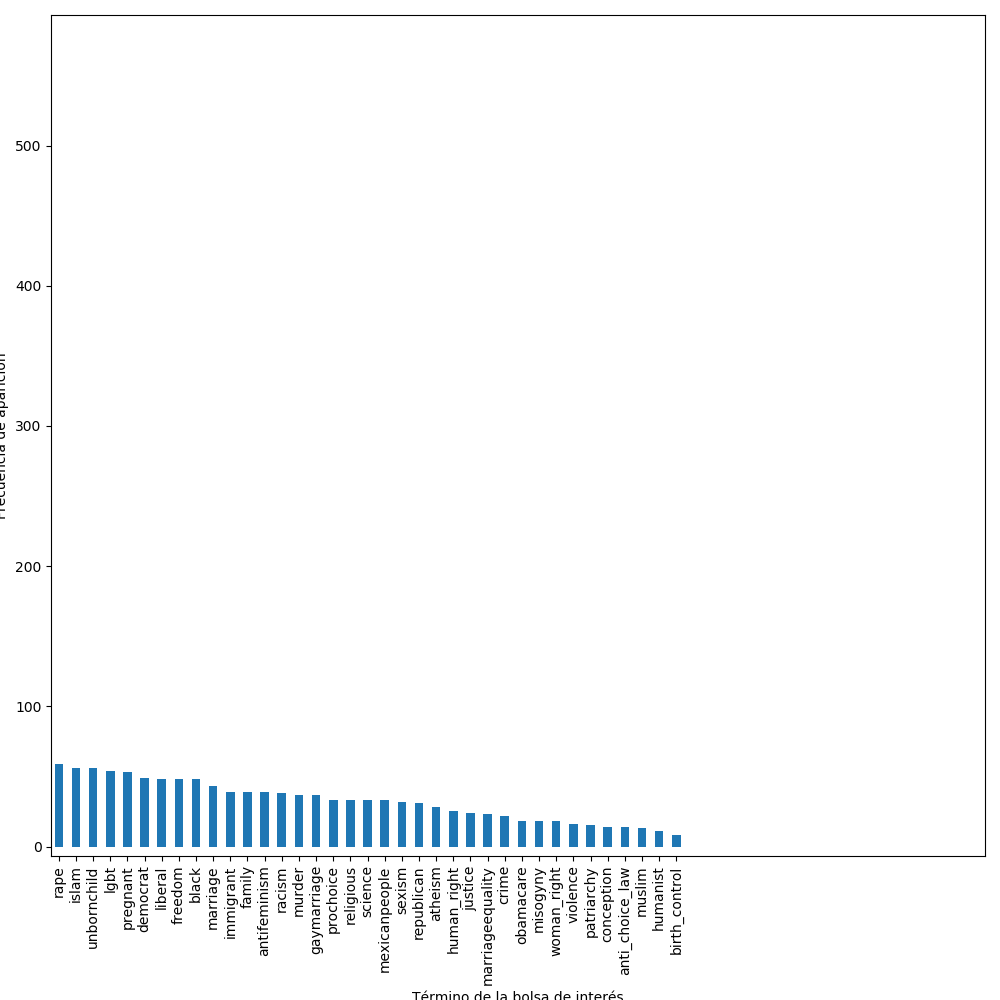

In [117]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

names, values = zip(*bow_words)
plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
indexes = np.arange(len(names))
width = 0.5
plt.bar(indexes, values, width)
plt.xticks(indexes, names)
plt.tight_layout()
plt.xlabel("Término de la bolsa de interés")
plt.ylabel("Frecuencia de aparición")
plt.show()
plt.savefig('FreqPlot.png',bbox_inches='tight')

In [118]:
def look_bow_terms(text_list,target,bow_l,target_dict):
    bow_text=[]
    for word in text_list:
        if word in bow_l:
            bow_text.append(word)
    bow_text.append(target_dict[target])
    final_text=list(set(bow_text))
    return final_text#" ".join(final_text).replace('  ',' ').lstrip()

In [119]:
df_usa["BOW_Tweet"] = df_usa.apply(lambda x: look_bow_terms(x['Token_Analyzed_Tweet'],x['Target'],bow,topicdic), axis=1)
df_usa.head()

ID           Target  \
0 2015-04-15 18:53:06.259  Hillary Clinton   
1 2015-04-15 18:53:09.828  Hillary Clinton   
2 2015-04-15 18:53:24.847  Hillary Clinton   
3 2015-04-15 18:53:53.254  Hillary Clinton   
4 2015-04-15 18:54:59.903  Hillary Clinton   

                                                                                                                            Tweet  \
0  ceo pay the target for election from someone who makes more than most ceo s but you drank the kool aid                           
1  @gunnjessica because i want young american women to be able to be proud of the st woman president #semst                         
2  @readyforhrc @hillaryclinton #hillaryclinton the us presidency is a testament to the success of #women their role in the world   
3  @chris @newsbusters years ago #hillary never answered whether she used private email #liberal media passed on reporting #semst   
4  i m on the edge of my seat to start volunteering for @hillaryclinton s presidential campaign so excited #cantwait                

    Stance Opinion towards Sentiment  \
0  NONE     OTHER           NEGATIVE   
1  FAVOR    OTHER           POSITIVE   
2  FAVOR    TARGET          POSITIVE   
3  AGAINST  TARGET          NEGATIVE   
4  FAVOR    TARGET          POSITIVE   

                                                                                                                                          Token_Tweet  \
0  [ceo, pay, the, target, for, election, from, someone, who, makes, more, than, most, ceo, s, but, you, drank, the, kool, aid]                         
1  [@gunnjessica, because, i, want, young, american, women, to, be, able, to, be, proud, of, the, st, woman, president, #semst]                         
2  [@readyforhrc, @hillaryclinton, #hillaryclinton, the, us, presidency, is, a, testament, to, the, success, of, #women, their, role, in, the, world]   
3  [@chris, @newsbusters, years, ago, #hillary, never, answered, whether, she, used, private, email, #liberal, media, passed, on, reporting, #semst]    
4  [i, m, on, the, edge, of, my, seat, to, start, volunteering, for, @hillaryclinton, s, presidential, campaign, so, excited, #cantwait]                

                                                                              Analyzed_Tweet  \
0  ceo pay target election ceo drank kool aid                                                  
1  gunnjessica young american woman able proud woman president semst                           
2  readyforhrc hillary_clinton hillary_clinton presidency testament success woman role world   
3  chris newsbusters year hillary_clinton private email liberal medium semst                   
4  edge seat hillary_clinton presidential campaign cantwait                                    

                                                                                  Token_Analyzed_Tweet  \
0  [ceo, pay, target, election, ceo, drank, kool, aid]                                                   
1  [gunnjessica, young, american, woman, able, proud, woman, president, semst]                           
2  [readyforhrc, hillary_clinton, hillary_clinton, presidency, testament, success, woman, role, world]   
3  [chris, newsbusters, year, hillary_clinton, private, email, liberal, medium, semst]                   
4  [edge, seat, hillary_clinton, presidential, campaign, cantwait]                                       

                                                Token_POSTag  Day  Month  \
0  [JJ, NN, NN, NN, JJ, JJ, NN, NN]                           15   4       
1  [USER, JJ, JJ, NNS, JJ, JJ, NN, NN, HASHTAG]               15   4       
2  [USER, USER, HASHTAG, NN, NN, NN, HASHTAG, NN, NN]         15   4       
3  [USER, USER, NNS, HASHTAG, JJ, JJ, HASHTAG, NNS, HASHTAG]  15   4       
4  [NN, NN, USER, JJ, NN, HASHTAG]                            15   4       

        Date                   BOW_Tweet  
0  4-15-2015  [hillary_clinton]           
1  4-15-2015  [hillary_clinton

In [120]:
df_usa.to_csv("usa_bow_analyzed_nlkt.csv")

### Fuzzy-CSar

In [121]:
df_usa_cs = pd.concat([df_usa["Date"],df_usa["BOW_Tweet"],df_usa["Sentiment"].str.lower()] ,axis=1, keys=['Date', 'BOW_Tweet', 'Sentiment'])
df_usa_csar = df_usa_cs.drop('BOW_Tweet', 1).join(
    pd.get_dummies(
        pd.DataFrame(df_usa_cs.BOW_Tweet.tolist()).stack()
    ).astype(int).sum(level=0)
)
df_usa_csar.head()

Date Sentiment  abortion  anti_choice_law  antifeminism  atheism  \
0  4-15-2015  negative  0         0                0             0         
1  4-15-2015  positive  0         0                0             0         
2  4-15-2015  positive  0         0                0             0         
3  4-15-2015  negative  0         0                0             0         
4  4-15-2015  positive  0         0                0             0         

   barack_obama  birth_control  black  catholic  ...  rape  religion  \
0  0             0              0      0         ...  0     0          
1  0             0              0      0         ...  0     0          
2  0             0              0      0         ...  0     0          
3  0             0              0      0         ...  0     0          
4  0             0              0      0         ...  0     0          

   religious  republican  science  sexism  unbornchild  violence  woman  \
0  0          0           0        0       0            0         0       
1  0          0           0        0       0            0         1       
2  0          0           0        0       0            0         1       
3  0          0           0        0       0            0         0       
4  0          0           0        0       0            0         0       

   woman_right  
0  0            
1  0            
2  0            
3  0            
4  0            

[5 rows x 52 columns]

In [122]:
df_usa_csar.to_csv("usa_fuzzycsar_nlkt.csv")

In [123]:
pandas2arff(df_usa_csar, "usa_arff_fcsar_nlkt.arff")

True

### IncMine

In [124]:
def look_inc_terms(bow_list,sentiment,date):
    bow_text=bow_list[:]
    bow_text.append(sentiment)
    bow_text.append(date)
    return bow_text

In [125]:
df_usa_inc = pd.concat([df_usa["Date"],df_usa["BOW_Tweet"],df_usa["Sentiment"].str.lower()] ,axis=1, keys=['Date', 'BOW_Tweet', 'Sentiment'])
df_usa_inc["IncM_Tweet"] = df_usa_inc.apply(lambda x: look_inc_terms(x['BOW_Tweet'],x['Sentiment'],x["Date"]), axis=1)
df_usa_inc.head()

Date                   BOW_Tweet Sentiment  \
0  4-15-2015  [hillary_clinton]           negative   
1  4-15-2015  [hillary_clinton, woman]    positive   
2  4-15-2015  [woman, hillary_clinton]    positive   
3  4-15-2015  [liberal, hillary_clinton]  negative   
4  4-15-2015  [hillary_clinton]           positive   

                                        IncM_Tweet  
0  [hillary_clinton, negative, 4-15-2015]           
1  [hillary_clinton, woman, positive, 4-15-2015]    
2  [woman, hillary_clinton, positive, 4-15-2015]    
3  [liberal, hillary_clinton, negative, 4-15-2015]  
4  [hillary_clinton, positive, 4-15-2015]

In [126]:
list_dates = df_usa_inc['Date'].apply(pd.Series).stack().tolist()
dates_usa = list(sorted(set(list_dates),key=list_dates.index))
keys_dates = range(1,len(dates_usa)+1)
dates_dict = dict(zip(dates_usa, keys_dates))

In [127]:
list_usa = ["positive","negative","neither"]+bow+df_usa_inc['Date'].apply(pd.Series).stack().tolist()
words_usa = list(sorted(set(list_usa),key=list_usa.index))
keys_usa = range(1,len(words_usa)+1)
ascii_dict = dict(zip(words_usa, keys_usa))

In [128]:
df_usa_inc["Keys_Tweet"] = df_usa_inc["IncM_Tweet"].map(lambda x: [ascii_dict[item] for item in x])
df_usa_inc.head()

Date                   BOW_Tweet Sentiment  \
0  4-15-2015  [hillary_clinton]           negative   
1  4-15-2015  [hillary_clinton, woman]    positive   
2  4-15-2015  [woman, hillary_clinton]    positive   
3  4-15-2015  [liberal, hillary_clinton]  negative   
4  4-15-2015  [hillary_clinton]           positive   

                                        IncM_Tweet      Keys_Tweet  
0  [hillary_clinton, negative, 4-15-2015]           [4, 2, 54]      
1  [hillary_clinton, woman, positive, 4-15-2015]    [4, 5, 1, 54]   
2  [woman, hillary_clinton, positive, 4-15-2015]    [5, 4, 1, 54]   
3  [liberal, hillary_clinton, negative, 4-15-2015]  [23, 4, 2, 54]  
4  [hillary_clinton, positive, 4-15-2015]           [4, 1, 54]

In [129]:
def zaki_stream(keylist,date,date_dictionary):
    date_key = date_dictionary[date]
    return [date_key,date_key,len(keylist)]+keylist

In [130]:
df_usa_inc["Zaki_Tweet"] = df_usa_inc.apply(lambda x: zaki_stream(x['Keys_Tweet'],x['Date'],dates_dict), axis=1)
df_usa_inc["Zaki_Tweet"] = df_usa_inc["Zaki_Tweet"].map(lambda x: [str(item) for item in x])
df_usa_inc["Zaki_Tweet"] = df_usa_inc["Zaki_Tweet"].apply(' '.join)
df_usa_inc.head()

Date                   BOW_Tweet Sentiment  \
0  4-15-2015  [hillary_clinton]           negative   
1  4-15-2015  [hillary_clinton, woman]    positive   
2  4-15-2015  [woman, hillary_clinton]    positive   
3  4-15-2015  [liberal, hillary_clinton]  negative   
4  4-15-2015  [hillary_clinton]           positive   

                                        IncM_Tweet      Keys_Tweet  \
0  [hillary_clinton, negative, 4-15-2015]           [4, 2, 54]       
1  [hillary_clinton, woman, positive, 4-15-2015]    [4, 5, 1, 54]    
2  [woman, hillary_clinton, positive, 4-15-2015]    [5, 4, 1, 54]    
3  [liberal, hillary_clinton, negative, 4-15-2015]  [23, 4, 2, 54]   
4  [hillary_clinton, positive, 4-15-2015]           [4, 1, 54]       

        Zaki_Tweet  
0  1 1 3 4 2 54     
1  1 1 4 4 5 1 54   
2  1 1 4 5 4 1 54   
3  1 1 4 23 4 2 54  
4  1 1 3 4 1 54

In [131]:
df_usa_inc.to_csv("usa_incmine_nlkt.csv")

In [132]:
#Estructura string separada por \n
keys_list = df_usa_inc["Zaki_Tweet"].tolist()
keys_string = "\n".join(keys_list)

In [133]:
#A ASCII
ascii_keys_string = keys_string.encode('ascii')
with open('usa_incmine_zaki_nlkt.ascii', 'wb') as ff:
    ff.write(ascii_keys_string)